In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from sklearn.cluster import KMeans
import os

In [46]:
# 환경 변수 설정 (Windows KMeans 메모리 누수 방지)
os.environ["OMP_NUM_THREADS"] = "1"

# 데이터 불러오기
df = pd.read_csv("final_mlb_season_stats_updated.csv")

# % 기호 제거 및 숫자로 변환 (FB%, GB%, HR/FB 컬럼)
def convert_percentage_to_float(column_name):
    if column_name in df.columns:
        df[column_name] = df[column_name].astype(str).str.rstrip("%").astype(float)

convert_percentage_to_float("FB%")
convert_percentage_to_float("GB%")
convert_percentage_to_float("HR/FB")

In [68]:
# 시대별 색상 정의 (한국어 변환)
era_colors = {
    "머니볼 이전": "gray",
    "머니볼 & 세이버메트릭스": "blue",
    "수비 시프트 & 데이터 분석": "green",
    "Statcast 도입 & 발사각 혁명": "orange",
    "삼진·볼넷·홈런 시대": "red"
}

# 전략 변화 연도 기준 시대 구분 함수
def define_era(season):
    if season >= 2002 and season < 2010:
        return "머니볼 & 세이버메트릭스"
    elif season >= 2010 and season < 2015:
        return "수비 시프트 & 데이터 분석"
    elif season >= 2015 and season < 2019:
        return "Statcast 도입 & 발사각 혁명"
    elif season >= 2019:
        return "삼진·볼넷·홈런 시대"
    else:
        return "머니볼 이전"

# 시대 컬럼 적용
df["era"] = df["season"].apply(define_era)

# 분석할 주요 메트릭 (한글 변환 포함)
metric_names = {
    "OPS": "OPS (출루율+장타율)",
    "BB%": "볼넷 비율 (BB%)",
    "BABIP": "인플레이 타율 (BABIP)",
    "K%": "삼진 비율 (K%)",
    "HR": "홈런 개수 (HR)",
    "ISO": "순수 장타력 (ISO)",
    "Launch_Angle": "발사각 (Launch Angle)",
    "FB%": "플라이볼 비율 (FB%)",
    "GB%": "땅볼 비율 (GB%)",
    "HR/FB": "홈런/플라이볼 비율 (HR/FB)"
}

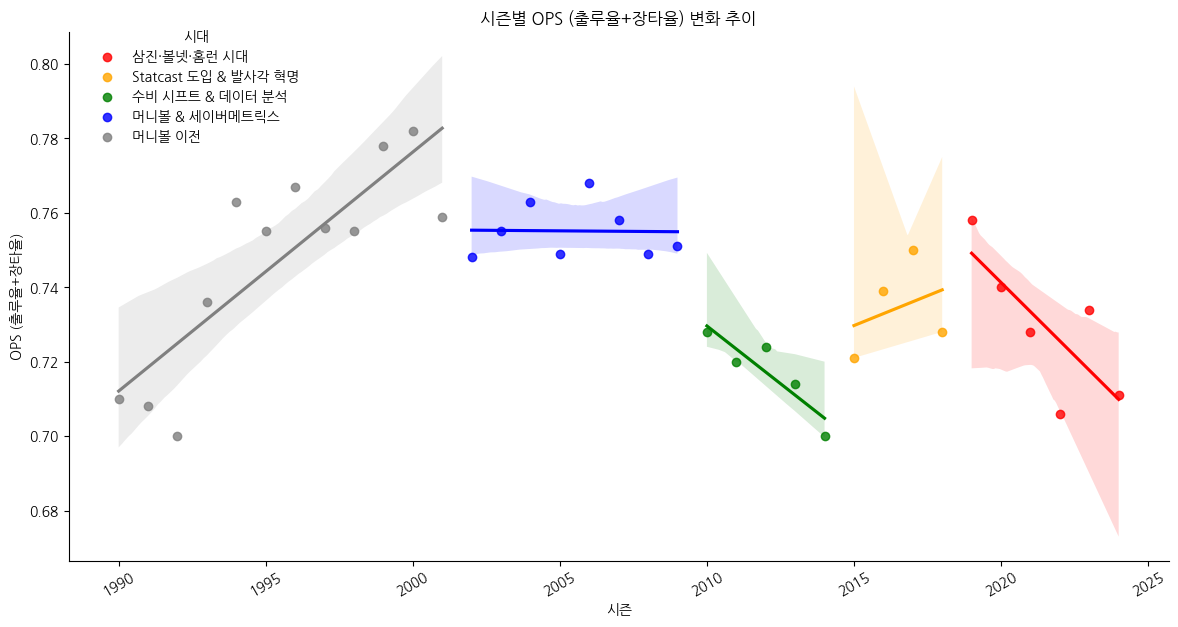

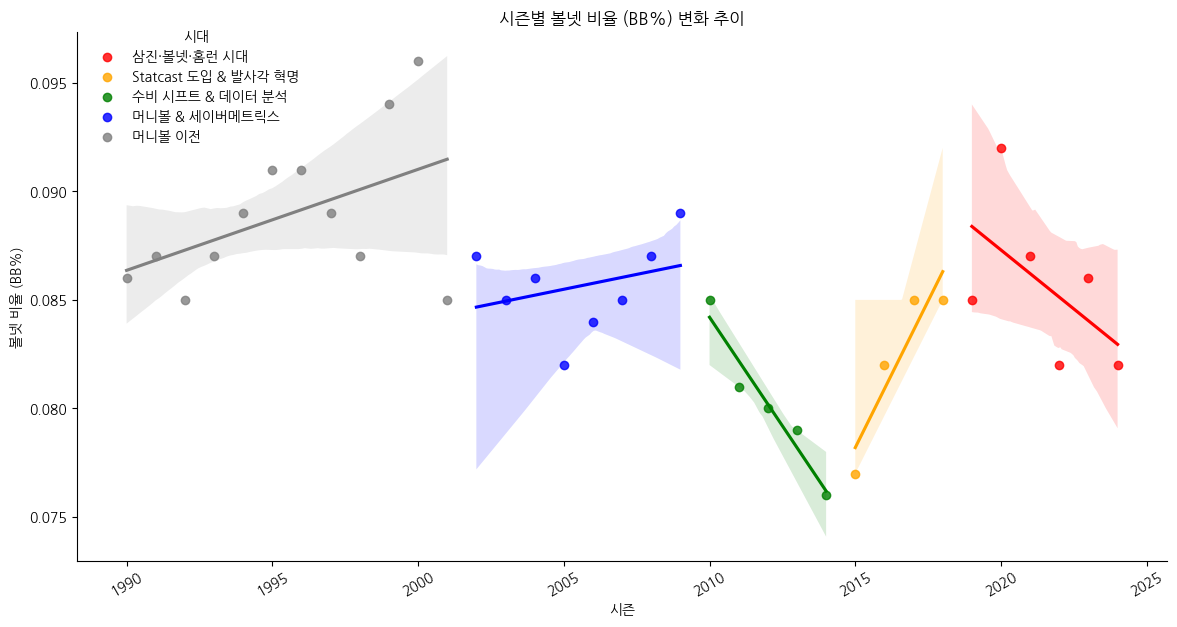

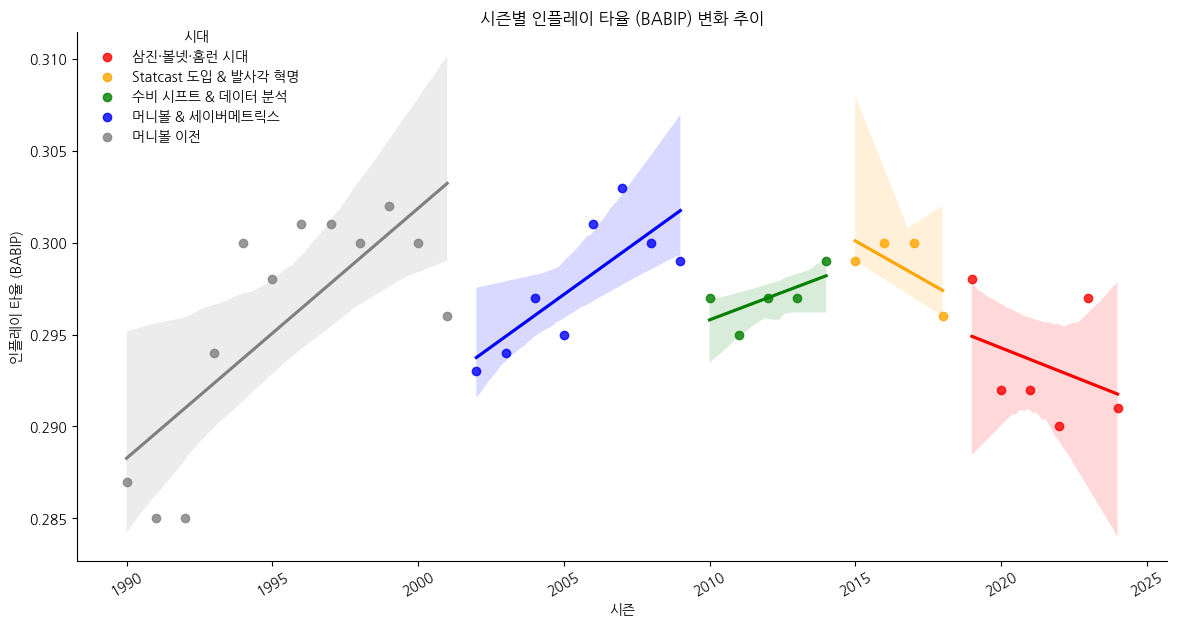

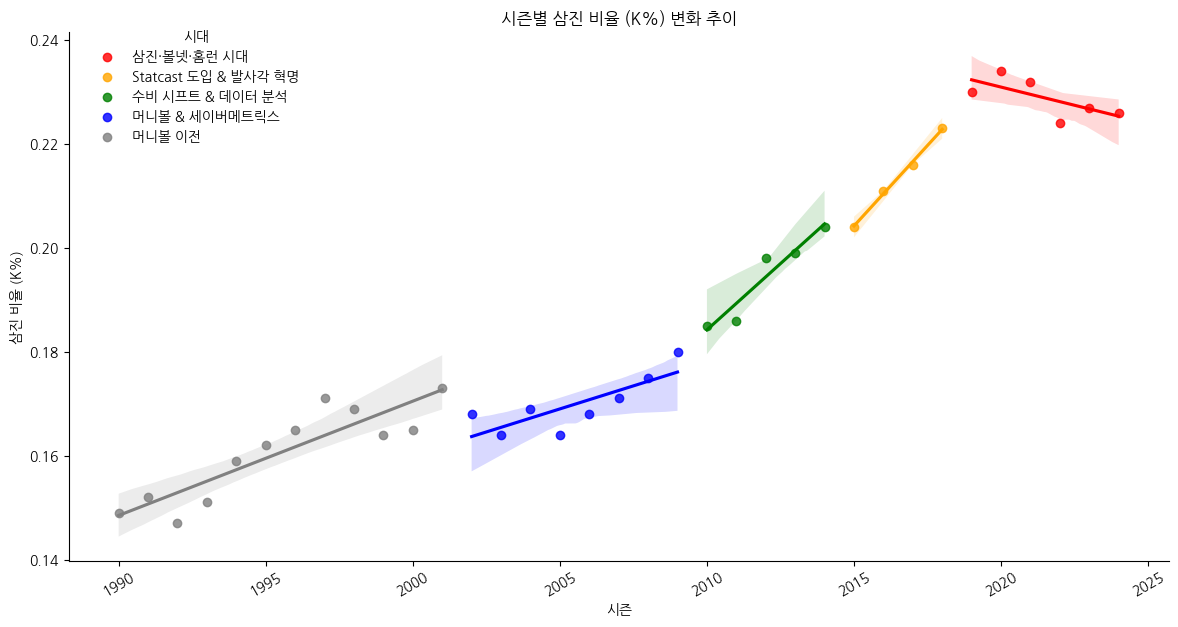

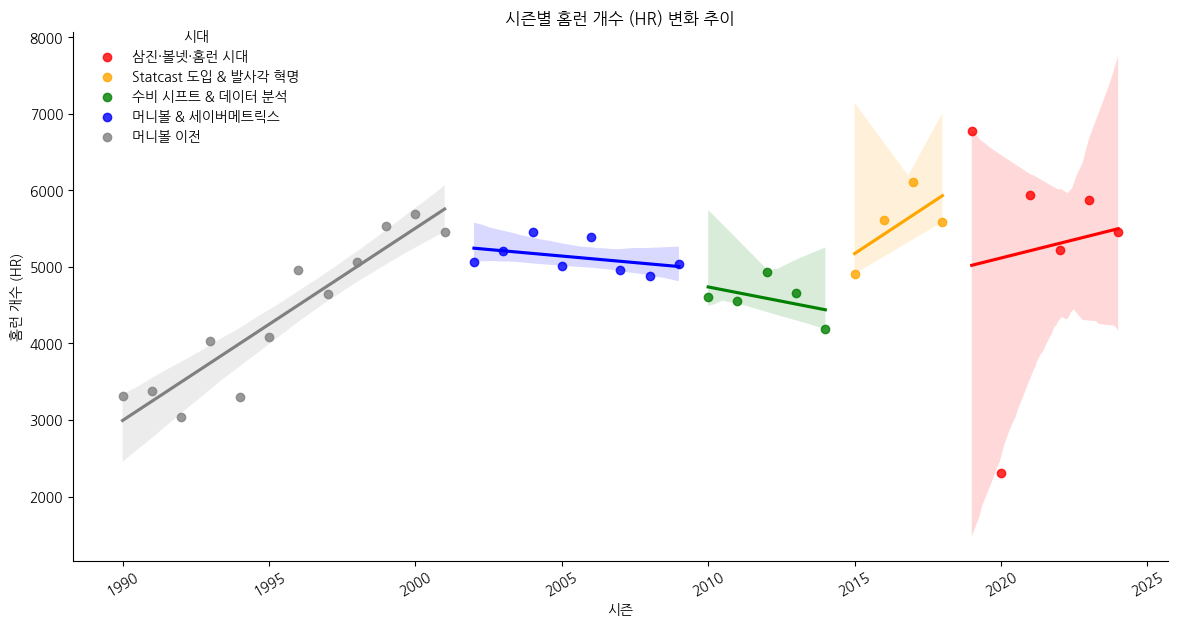

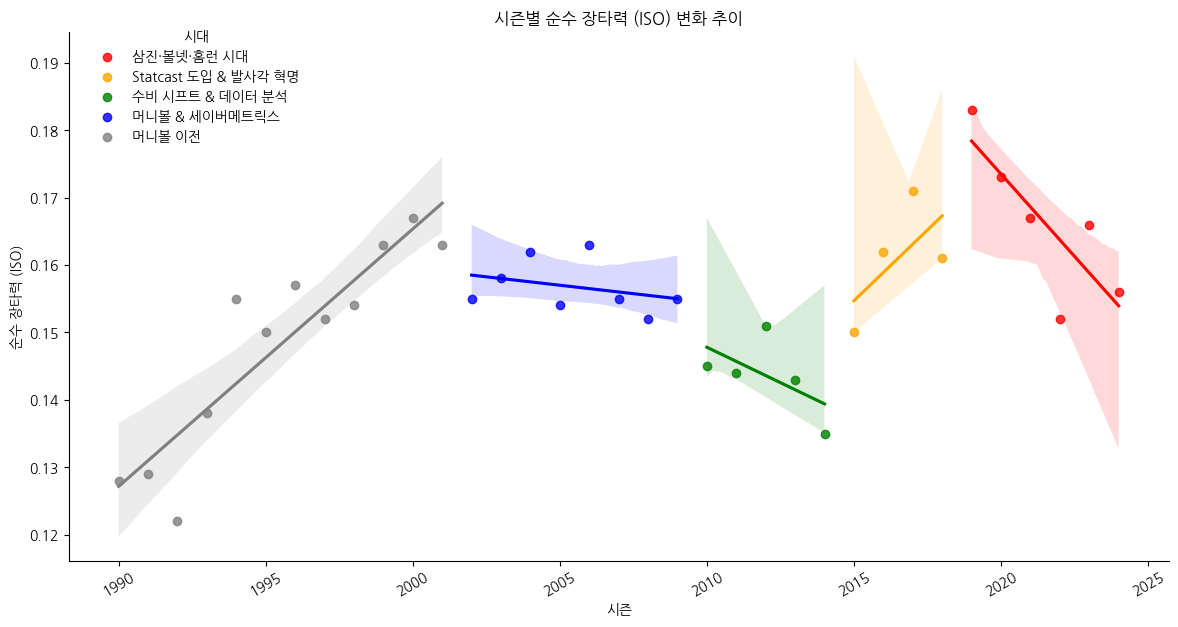

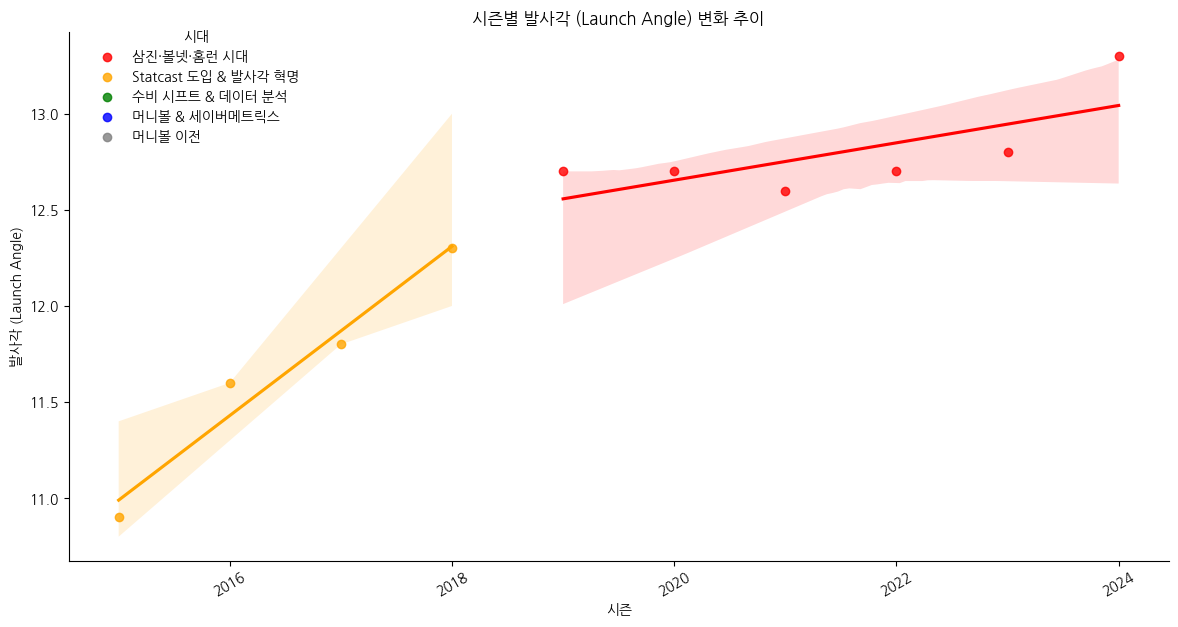

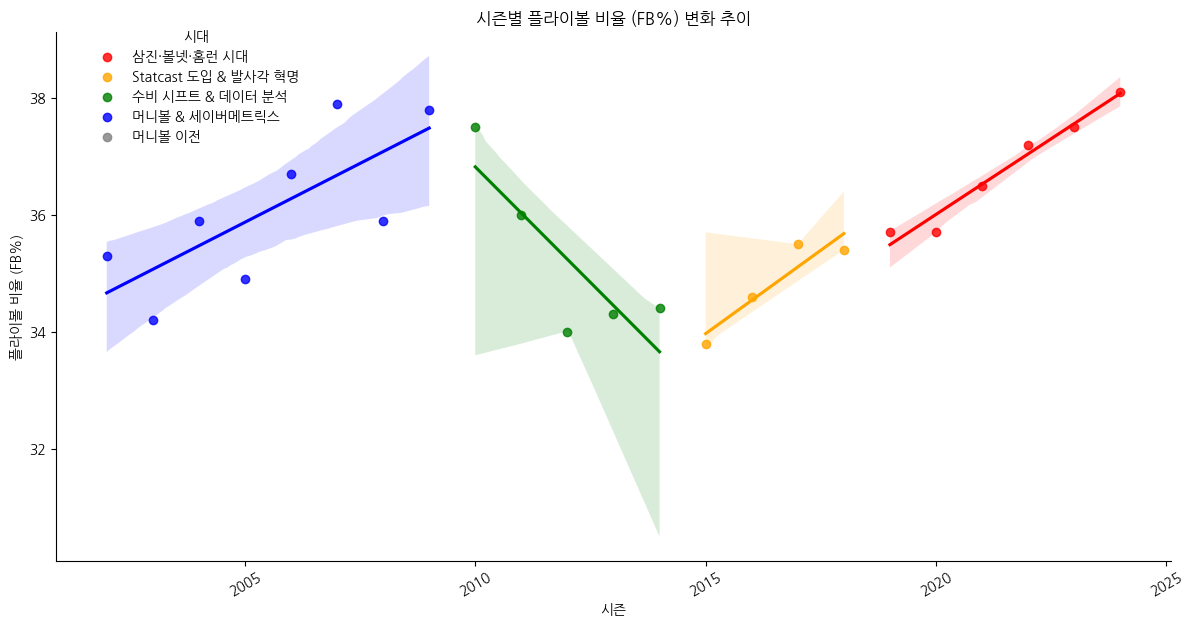

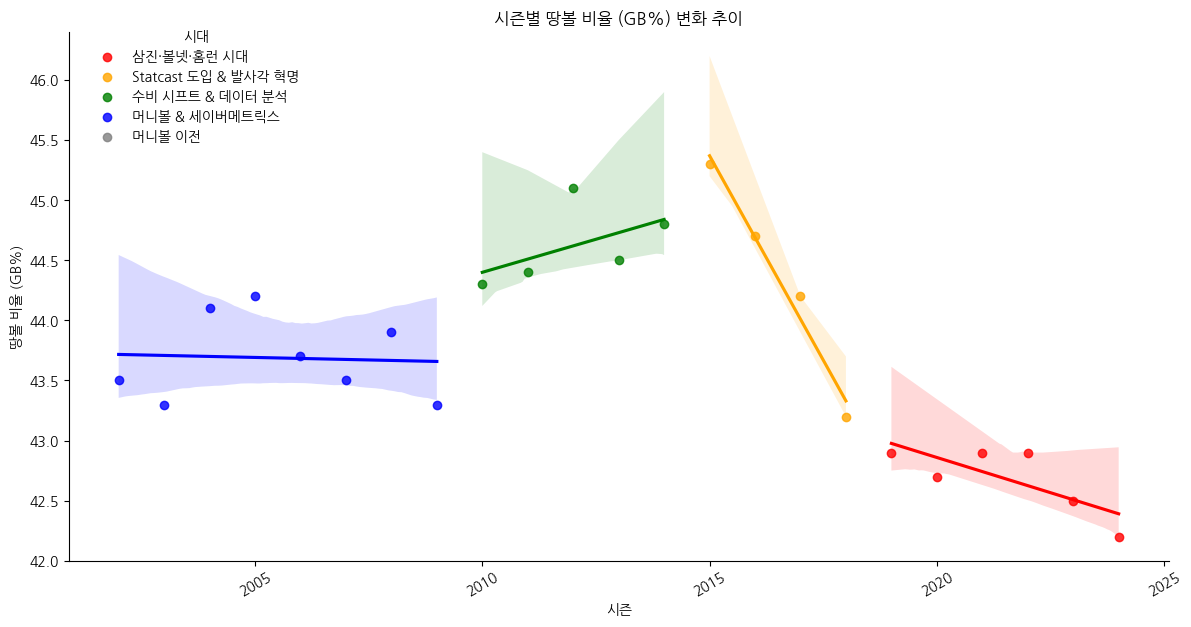

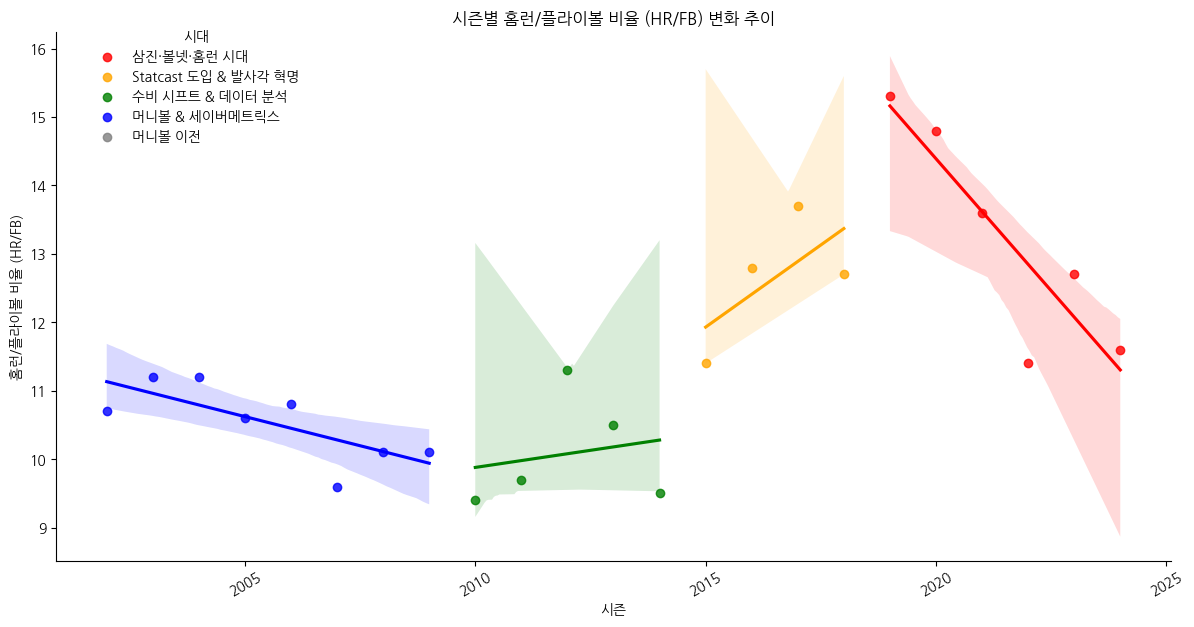

In [69]:
# 회귀선 그래프 (Seaborn 사용, 전략 변화 시대 적용)
def plot_trend_with_seaborn(metric, metric_korean):
    g = sns.lmplot(data=df, x="season", y=metric, hue="era", palette=era_colors, height=6, aspect=2, ci=95)  # 가로로 더 길게 설정
    g.set(title=f"시즌별 {metric_korean} 변화 추이", xlabel="시즌", ylabel=metric_korean)
    
    # 범례를 왼쪽 위로 이동
    g._legend.set_bbox_to_anchor((0.22, 0.9))  # 범례를 그래프 안쪽 왼쪽 위로 이동
    g._legend.set_title("시대")  # 범례 제목 설정
    
    plt.xticks(rotation=30)
    plt.show()

# 모든 메트릭에 대해 개별 그래프 생성 (한글 적용)
for metric, metric_korean in metric_names.items():
    plot_trend_with_seaborn(metric, metric_korean)


c:\Users\KDT-2\anaconda3\envs\EV_PY312\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KDT-2\anaconda3\envs\EV_PY312\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KDT-2\anaconda3\envs\EV_PY312\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\KDT-2\anaconda3\envs\EV_PY312\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

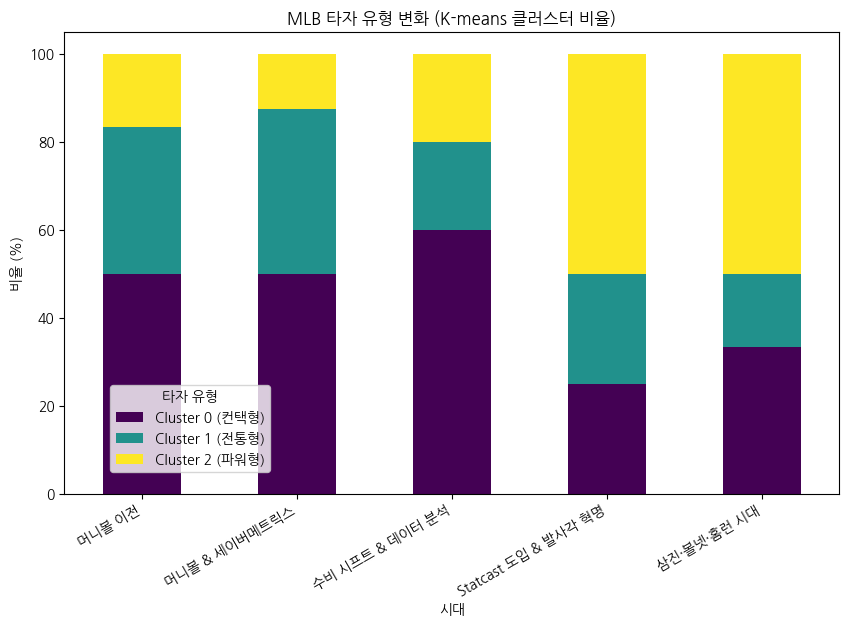

In [ ]:
# K-means 클러스터링 (타자 유형 분석)
cluster_features = ["HR", "K%", "BB%", "ISO"]
df_scaled = df.dropna(subset=cluster_features).copy()
df_scaled[cluster_features] = (df_scaled[cluster_features] - df_scaled[cluster_features].mean()) / df_scaled[cluster_features].std()

# KMeans 모델 실행
# 각 시대별 타자 데이터를 K-means(3개 군집)로 군집화.
# 시대별 군집(컨택형, 전통형, 파워형)의 비율을 저장.
era_clusters = {}
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
for era in era_colors.keys():
    era_data = df_scaled[df_scaled["era"] == era][cluster_features].to_numpy()
    if era_data.shape[0] > 0:
        df_scaled.loc[df_scaled["era"] == era, "Cluster"] = kmeans.fit_predict(era_data)
        cluster_counts = np.bincount(kmeans.labels_, minlength=3) / len(kmeans.labels_) * 100
        era_clusters[era] = cluster_counts

# 클러스터 비율 데이터프레임 생성
era_cluster_df = pd.DataFrame.from_dict(era_clusters, orient="index", columns=["Cluster 0 (컨택형)", "Cluster 1 (전통형)", "Cluster 2 (파워형)"])

# 스택 바 그래프 생성
fig, ax = plt.subplots(figsize=(10, 6))
era_cluster_df.plot(kind="bar", stacked=True, ax=ax, colormap="viridis")
ax.set_title("MLB 타자 유형 변화 (K-means 클러스터 비율)")
ax.set_xlabel("시대")
ax.set_ylabel("비율 (%)")
ax.legend(title="타자 유형", loc='upper left', bbox_to_anchor=(0.05, 0.25))  # 범례를 그래프 안으로 이동
plt.xticks(rotation=30, ha='right')  # x축 글씨 회전하여 겹침 방지
plt.show()

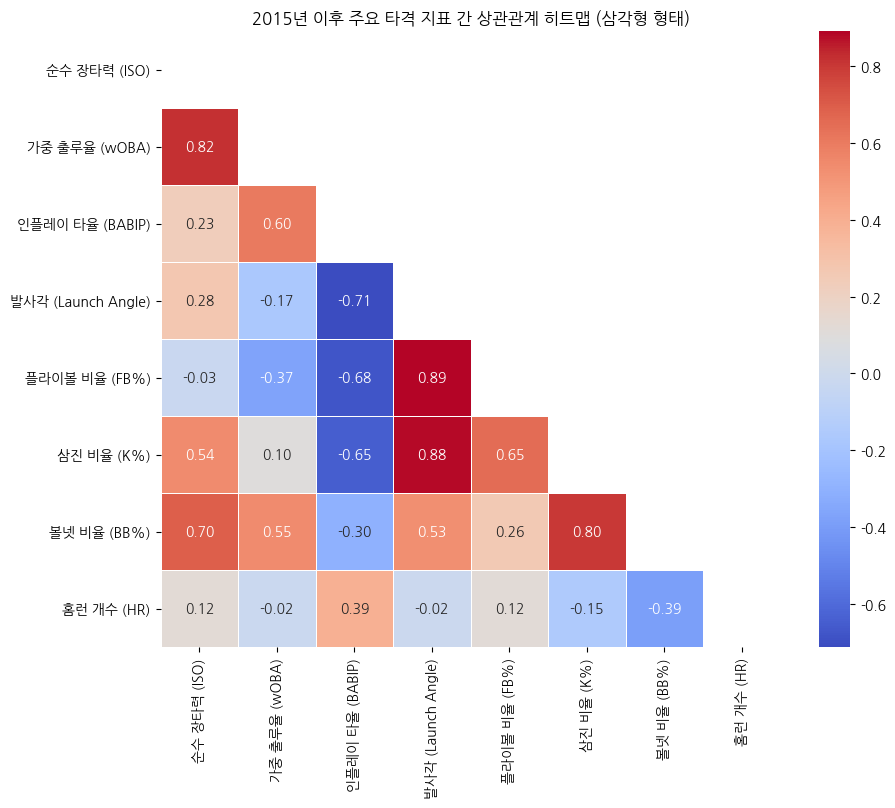

In [52]:
# 2015년 이후 데이터만 필터링
df_filtered = df[df["season"] >= 2015].copy()

# 상관계수 분석할 지표 선택 (metric_names 활용)
correlation_metrics = ["ISO", "wOBA", "BABIP", "Launch_Angle", "FB%", "K%", "BB%", "HR"]

# 해당 지표만 포함한 상관계수 행렬 생성
corr_matrix = df_filtered[correlation_metrics].corr()

# 한글 변환된 지표 이름 매핑
renamed_columns = {metric: metric_names[metric] for metric in correlation_metrics}
corr_matrix.rename(columns=renamed_columns, index=renamed_columns, inplace=True)

# 삼각형 마스크 생성 (윗부분 제거)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# 상관계수 히트맵 시각화 (삼각형 형태)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("2015년 이후 주요 타격 지표 간 상관관계 히트맵 (삼각형 형태)")
plt.show()
